In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_validate
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb


import gc


df = pd.read_csv('./output/train.csv')


In [2]:
df.isna().sum(axis=1)
print(len(df))
df = df.dropna(axis=0)
print(len(df))

# no games from 2011 bc they have nans
with pd.option_context('mode.use_inf_as_na', True):
    df = df.fillna(0)
    

106368
85070


In [3]:
y = df.target
X = df.drop(columns=['target'])


# using LGBM gain
to_drop = ['Sea_FT_x','Sea_FT_y','wSea_OReb_x','wSea_OReb_y','wSea_2pt_x','wSea_2pt_y','wSea_3pt_x','wSea_3pt_y']
X = X.drop(columns=to_drop)


In [4]:
scaler = StandardScaler()
cat = []
num = [i for i in list(X)]

X[num] = scaler.fit_transform(X[num])

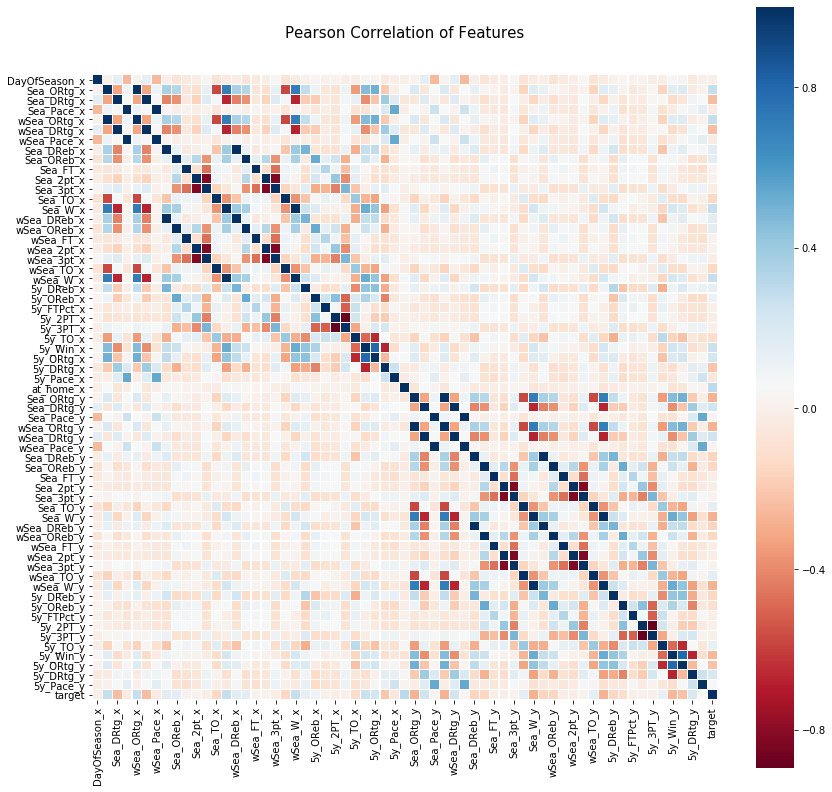

In [5]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,14))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=False)



In [6]:
#Validation function
n_folds = 5

feat_names = list(X)

def mae_cv(model, lin_reg=False):

    kf = KFold(n_folds, shuffle=True, random_state=17).get_n_splits(X.values)
    output = cross_validate(model, X.values, y, cv=kf, scoring = 'neg_mean_absolute_error', return_estimator=True)
    all_estimators = []
    for idx,estimator in enumerate(output['estimator']):
        if lin_reg:
            all_estimators.append(list(estimator.coef_))
        else:  
            all_estimators.append(list(estimator.feature_importances_))
    
    all_estimators = pd.DataFrame(all_estimators)
    avg_imp = all_estimators.values.mean(axis=0)
    feature_importances = pd.DataFrame(avg_imp, index = feat_names,
                                       columns=['importance']).sort_values('importance', ascending=False)
    
    feature_importances = feature_importances.reset_index()
    feature_importances.columns = ['feats','importance']
#     print(feature_importances)
    return output, feature_importances



Lin_Reg score: 9.2789 (0.1038)



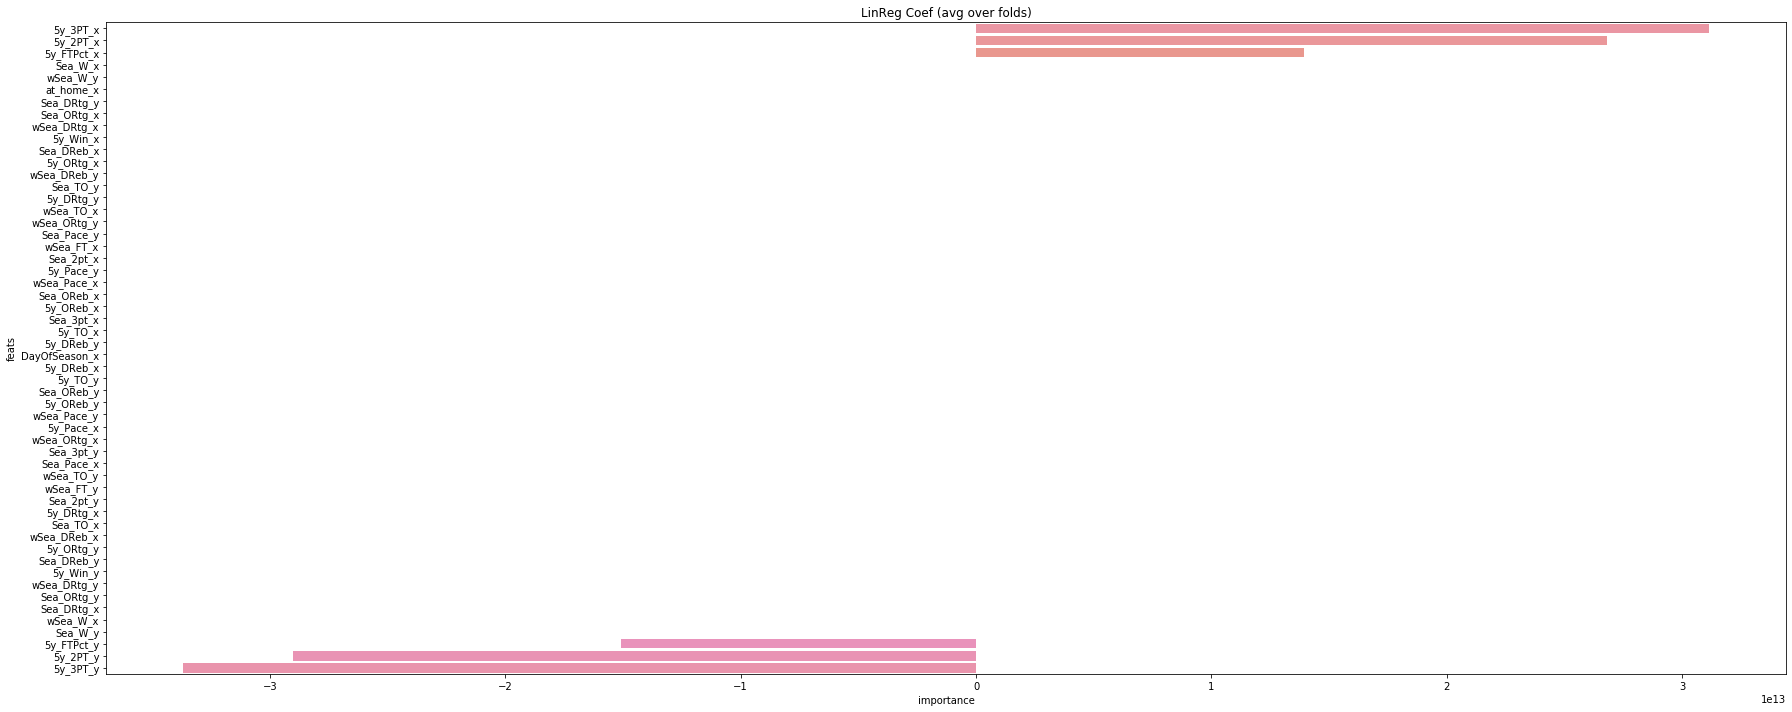

In [7]:
lin_reg = LinearRegression()

output, feat_imp = mae_cv(lin_reg, lin_reg=True)
print("Lin_Reg score: {:.4f} ({:.4f})\n" .format(-1*output['test_score'].mean(), output['test_score'].std()))

plt.figure(figsize=(25, 10))
sns.barplot(x="importance", y="feats", data=feat_imp)
plt.title('LinReg Coef (avg over folds)')
plt.tight_layout()
plt.savefig('./figures/linreg_importances-02.png')
plt.show()

In [8]:
# score = mae_cv(ENet)
# print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


LGBM score: 9.1462 (0.1108)



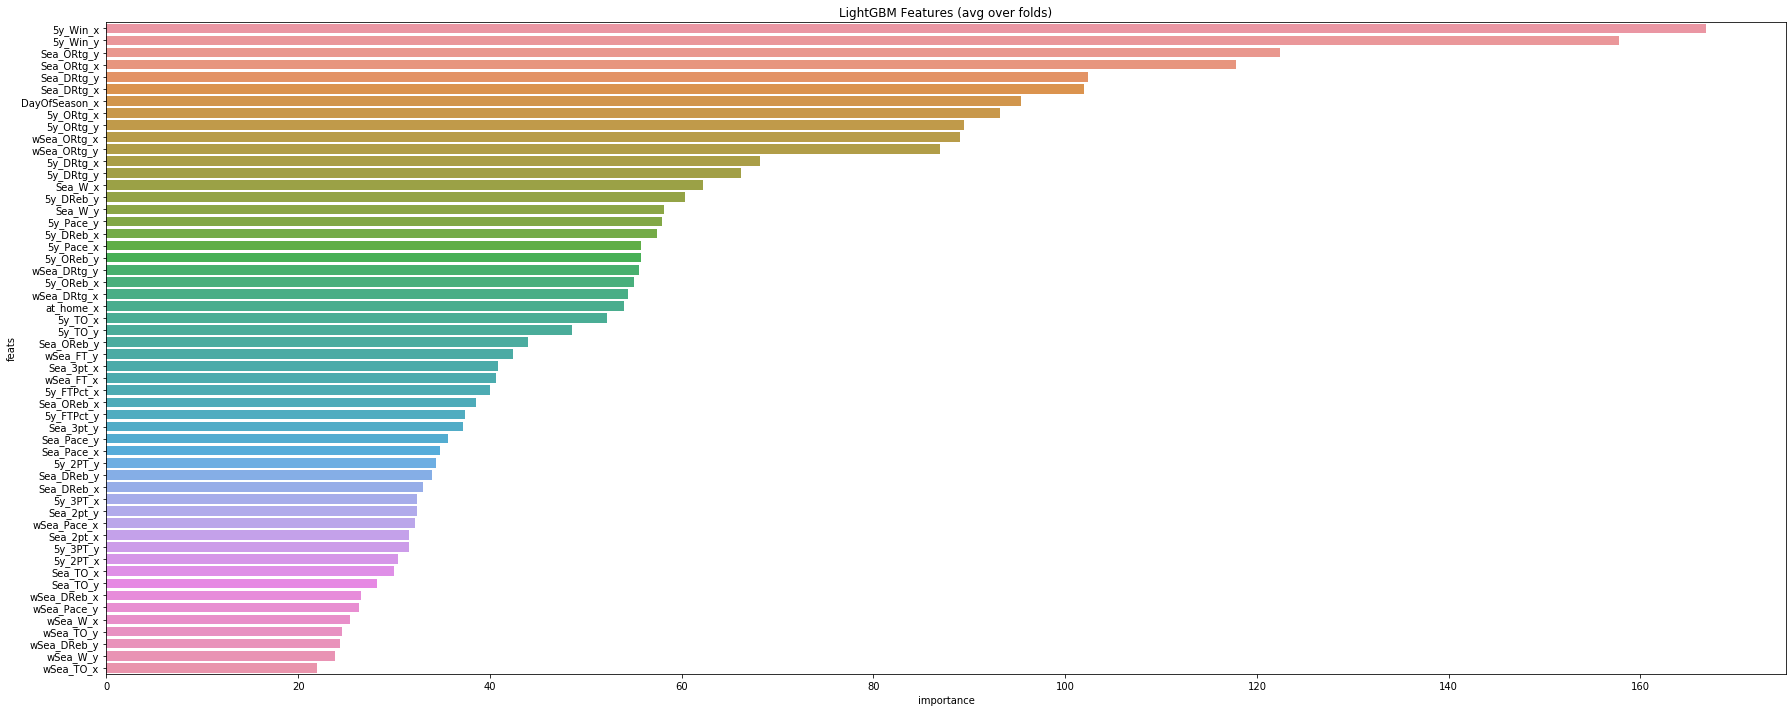

In [9]:
model_lgb = lgb.LGBMRegressor(objective='regression',learning_rate=0.09,importance='gain')

output, feat_imp = mae_cv(model_lgb)
# dict_keys(['fit_time', 'score_time', 'estimator', 'test_score'])

#9.1524
print("LGBM score: {:.4f} ({:.4f})\n" .format(-1*output['test_score'].mean(), output['test_score'].std()))

plt.figure(figsize=(25, 10))
sns.barplot(x="importance", y="feats", data=feat_imp)
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('./figures/lgbm_importances-02.png')
plt.show()


In [10]:
# to drop
to_drop = ['Sea_FT_x','Sea_FT_y','wSea_OReb_x','wSeaOReb_y','wSea_2pt_x','wSea_2pt_y','wSea_3pt_x','wSea_3pt_y']

len(to_drop)

8

In [ ]:
from lofo import LOFOImportance, Dataset, plot_importance
